In [1]:
import os
import sys
# We add the backend folder to our path to do imports from the main module
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

import pickle
from multiprocessing import Pool
import multiprocessing as mp
import pypianoroll
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import glob
from collections import defaultdict
from collections import Counter
from backend.ml_model.experiments.helper import average_notes_per_timestep_for_file, calculate_statistics_per_file
import numpy as np

In [2]:
def get_dataset_statistics_per_track(num_processes=16):
    """ Calculate how many notes for each instrument land on every resolution step"""
    result_filepath_base = os.path.join(os.getcwd(), '..', 'plots', 'dataset_statistics_per_track')
    pickle_filepath = f'{result_filepath_base}.pkl'

    if not os.path.exists(pickle_filepath):
        # Get all files
        file_paths = glob.glob(os.path.join(os.getcwd(), '..', 'lpd_5/lpd_5_cleansed/*/*/*/*/*.npz'))
        print(f'Found {len(file_paths)} files to process')

        if num_processes is None:
            num_processes = mp.cpu_count()

        print(f'Using {num_processes} processes')

        # Initialize result containers
        resolutions = set()
        total_files = 0
        total_timesteps = 0

        # Track-specific resolution steps counters
        track_resolution_steps = {
            'Drums': {step: 0 for step in range(25)},
            'Piano': {step: 0 for step in range(25)},
            'Guitar': {step: 0 for step in range(25)},
            'Bass': {step: 0 for step in range(25)},
            'Strings': {step: 0 for step in range(25)}
        }

        # Track type occurrence counter
        track_type_counts = {
            'Drums': 0,
            'Piano': 0,
            'Guitar': 0,
            'Bass': 0,
            'Strings': 0
        }

        # Process files using multiprocessing
        with Pool(processes=num_processes) as pool:
            results = list(tqdm(
                pool.imap_unordered(calculate_statistics_per_file, file_paths, chunksize=50),
                total=len(file_paths),
                desc='Processing files'
            ))

        # Aggregate results
        failed_files = []
        for result in results:
            if result['success']:
                total_files += 1
                resolutions.add(result['resolution'])
                total_timesteps += result['max_length']

                # Count track types in this file
                for track_type in result['track_types']:
                    if track_type in track_type_counts:
                        track_type_counts[track_type] += 1

                # Aggregate track-specific resolution steps
                for track_type, steps_dict in result['track_resolution_steps'].items():
                    if track_type in track_resolution_steps:
                        for step, count in steps_dict.items():
                            track_resolution_steps[track_type][step] += count
            else:
                failed_files.append((result['file_path'], result['error']))

        # Print any failed files
        if failed_files:
            print(f'\n{len(failed_files)} files failed to process:')
            for file_path, error in failed_files[:10]:
                print(f'{file_path}: {error}')

        with open(pickle_filepath, 'wb') as f:
            pickle.dump([resolutions, track_type_counts, track_resolution_steps], f)
    else:
        print(f'Loading results from file.')

        with open(pickle_filepath, 'rb') as f:
            resolutions, track_type_counts, track_resolution_steps = pickle.load(f)

    # Print statistics
    print(f'\nUnique resolutions found: {sorted(resolutions)}')

    print('\nTrack type occurrences:')
    for track_type, count in track_type_counts.items():
        print(f'{track_type}: {count} tracks')

    # === MODIFIED PLOTTING SECTION ===
    print('\nGenerating separate plots...')

    track_types = ['Bass', 'Drums', 'Piano', 'Guitar', 'Strings']

    for track_type in track_types:
        # Create a new, separate figure for each instrument
        fig, ax = plt.subplots(figsize=(10, 6)) # Good size for a single plot

        # Your logic used 25 steps, so we plot 0-24
        steps = list(range(25))
        counts = [track_resolution_steps[track_type][step] for step in steps]

        # Only plot if there are notes for this track
        if sum(counts) > 0:
            ax.bar(steps, counts)
            ax.set_title(f'{track_type} - Note Onset Distribution (24 PPQN)')
            ax.set_xlabel('Step within Quarter Note')
            ax.set_ylabel('Number of Note Onsets')
            ax.set_xticks(range(0, 25, 2)) # Show ticks every 2 steps
            ax.grid(True, linestyle='--', alpha=0.5)

            # Define the output filename for this specific plot
            plot_filename = f'{result_filepath_base}_{track_type}.png'
            plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
            print(f'Saved plot: {plot_filename}')

        else:
            # Handle tracks with no data
            ax.text(0.5, 0.5, f'No note onsets found\nfor {track_type}',
                    ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{track_type} - No Data')

            plot_filename = f'{result_filepath_base}_{track_type}_no_data.png'
            plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
            print(f'Saved plot (no data): {plot_filename}')

        # Show the plot (optional, can be noisy)
        # plt.show()

        # Close the figure to free up memory before the next loop
        plt.close(fig)

    print('All plots generated and saved.')

get_dataset_statistics_per_track()

Found 21425 files to process
Using 16 processes


Processing files: 100%|██████████| 21425/21425 [17:51<00:00, 19.99it/s]



Unique resolutions found: [24]

Track type occurrences:
Drums: 21425 tracks
Piano: 21425 tracks
Guitar: 21425 tracks
Bass: 21425 tracks
Strings: 21425 tracks

Generating separate plots...
Saved plot: C:\Users\mbrun\Documents\University_Branche\Project\webserver\backend\ml_model\experiments\..\plots\dataset_statistics_per_track_Bass.png
Saved plot: C:\Users\mbrun\Documents\University_Branche\Project\webserver\backend\ml_model\experiments\..\plots\dataset_statistics_per_track_Drums.png
Saved plot: C:\Users\mbrun\Documents\University_Branche\Project\webserver\backend\ml_model\experiments\..\plots\dataset_statistics_per_track_Piano.png
Saved plot: C:\Users\mbrun\Documents\University_Branche\Project\webserver\backend\ml_model\experiments\..\plots\dataset_statistics_per_track_Guitar.png
Saved plot: C:\Users\mbrun\Documents\University_Branche\Project\webserver\backend\ml_model\experiments\..\plots\dataset_statistics_per_track_Strings.png
All plots generated and saved.


In [30]:
def calculate_discarded_notes_statistics():
    """ Calculate how many drum notes we would """
    # Load the pickle file containing dataset statistics
    pickle_path = os.path.join(os.getcwd(), '..', 'plots', 'dataset_statistics_per_track')

    with open(f'{pickle_path}.pkl', 'rb') as f:
        resolutions, track_type_counts, track_resolution_steps = pickle.load(f)

    # Define encoding resolutions to test
    encoding_resolutions = [2, 4, 8, 12, 24]

    for encoding_resolution in encoding_resolutions:
        print(f'\nEncoding Resolution: {encoding_resolution}')

        # Calculate step size: 24 // encoding_resolution
        step = 24 // encoding_resolution

        # Note the dataset size in steps
        dataset_size = 0
        covered_dataset_size = 0

        # For each track, calculate what percentage of steps will be covered
        for track_name in ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']:
            track_steps = track_resolution_steps[track_name]

            # Sum up steps where the index can be cleanly divided by step
            covered_steps = 0
            total_steps = 0

            for step_index in range(25):  # 0 to 24
                count = track_steps[step_index]
                total_steps += count

                # Check if step_index is divisible by step
                if step_index % step == 0:
                    covered_steps += count

            covered_dataset_size += covered_steps
            dataset_size += total_steps

            # Calculate percentage
            if total_steps > 0:
                percentage = (covered_steps / total_steps) * 100
                print(f'{track_name:8}: {percentage:6.2f}% ({covered_steps:,}/{total_steps:,} steps)')
            else:
                print(f'{track_name:8}: No data available')

        percentage = (covered_dataset_size / dataset_size) * 100
        print(f'Complete size: {percentage:6.2f}% ({covered_dataset_size:,}/{dataset_size:,} steps)')
        print('-' * 30)

calculate_discarded_notes_statistics()


Encoding Resolution: 2
Drums   :  36.52% (7,139,627/19,550,419 steps)
Piano   :   8.84% (8,297,372/93,882,835 steps)
Guitar  :   9.05% (8,642,863/95,449,649 steps)
Bass    :   9.33% (12,012,319/128,801,314 steps)
Strings :   8.62% (12,859,962/149,148,833 steps)
Complete size:  10.06% (48,952,143/486,833,050 steps)
------------------------------

Encoding Resolution: 4
Drums   :  48.91% (9,561,736/19,550,419 steps)
Piano   :  17.17% (16,120,785/93,882,835 steps)
Guitar  :  17.43% (16,635,914/95,449,649 steps)
Bass    :  17.82% (22,958,625/128,801,314 steps)
Strings :  16.98% (25,323,538/149,148,833 steps)
Complete size:  18.61% (90,600,598/486,833,050 steps)
------------------------------

Encoding Resolution: 8
Drums   :  51.43% (10,055,565/19,550,419 steps)
Piano   :  33.65% (31,592,310/93,882,835 steps)
Guitar  :  33.91% (32,367,300/95,449,649 steps)
Bass    :  34.21% (44,065,349/128,801,314 steps)
Strings :  33.54% (50,031,518/149,148,833 steps)
Complete size:  34.53% (168,112,042/

Loading cleansed IDs from C:\Users\mbrun\Documents\University_Branche\Project\webserver\backend\ml_model\experiments\..\lpd_5\cleansed_ids.txt...
Loaded 21,425 unique MSD IDs

  Total unique songs with labels: 10674 out of 21425 (49.8%)


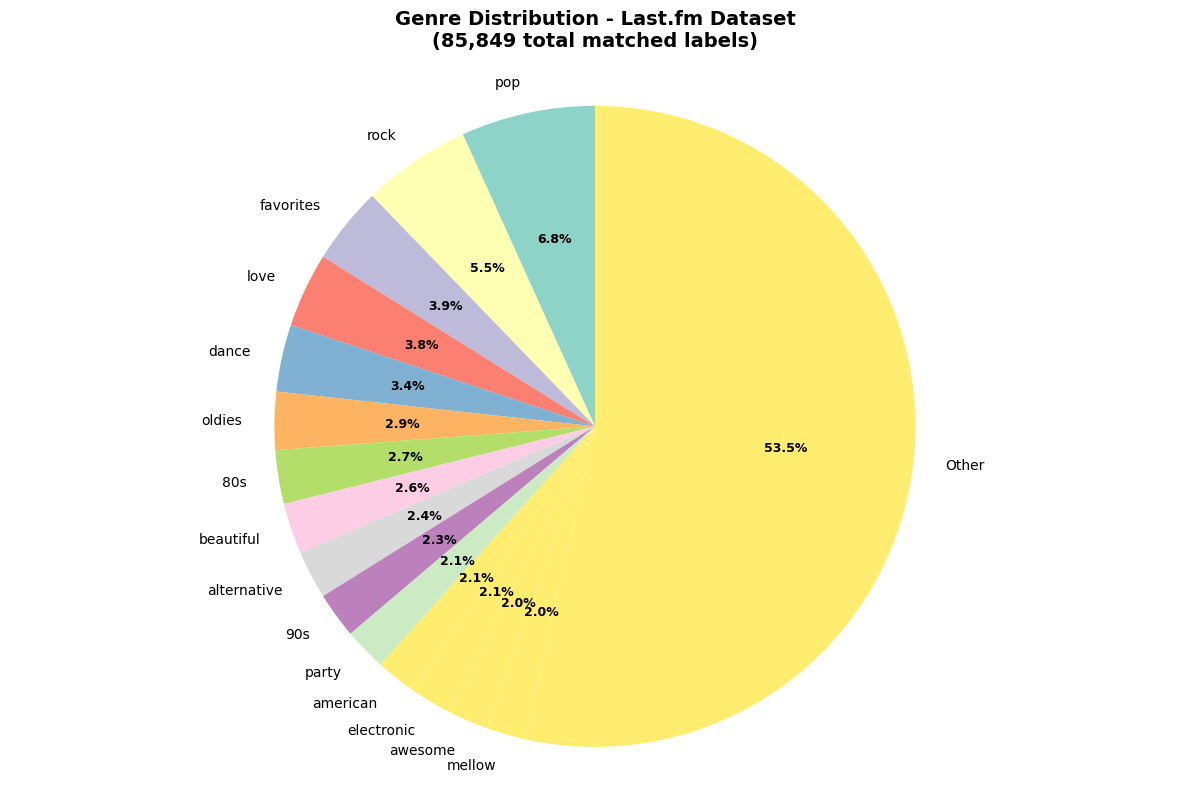


  Total unique songs with labels: 7323 out of 21425 (34.2%)


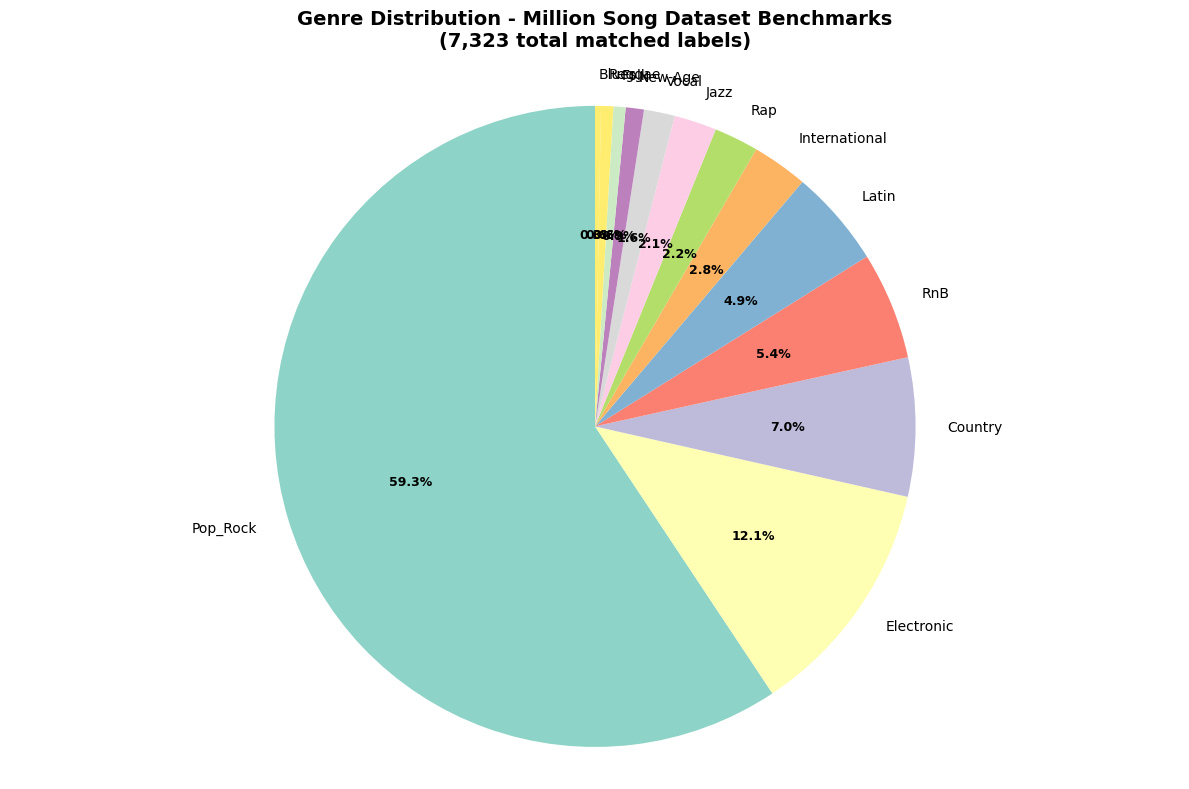


  Total unique songs with labels: 4372 out of 21425 (20.4%)


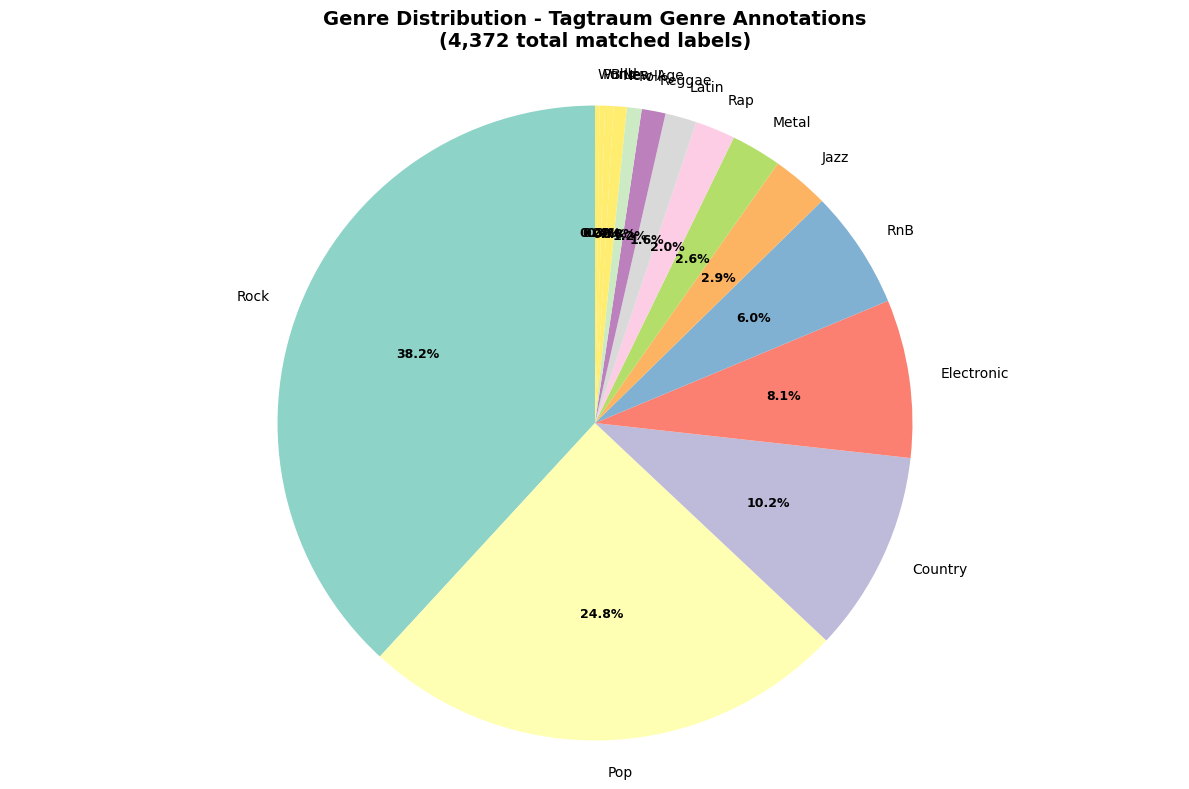

In [29]:
def load_cleansed_ids(cleansed_ids_file):
    print(f'Loading cleansed IDs from {cleansed_ids_file}...')
    msd_ids = set()

    with open(cleansed_ids_file, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            if line_num % 100000 == 0:
                print(f'Processed {line_num:,} lines...')

            line = line.strip()
            if line:
                parts = line.split()
                if len(parts) >= 2:
                    msd_id = parts[1].strip()
                    if msd_id.startswith('TR') and len(msd_id) == 18:
                        msd_ids.add(msd_id)

    print(f'Loaded {len(msd_ids):,} unique MSD IDs')
    return msd_ids


def process_label_provider_folder(folder_path, msd_ids_set):
    """
    Process a label provider folder and count genre occurrences for our songs.
    """
    genre_counts = defaultdict(int)
    id_list_files = glob.glob(os.path.join(folder_path, 'id_list_*.txt'))

    if not id_list_files:
        print(f'No id_list_*.txt files found in {folder_path}')
        return genre_counts

    # Track unique songs that have at least one label
    labeled_songs = set()
    for file_path in id_list_files:
        # Extract genre name from filename
        filename = os.path.basename(file_path)
        genre = filename.replace('id_list_', "").replace('.txt', "")

        # Count how many of our songs are in this genre
        count = 0
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    msd_id = line.strip()
                    if msd_id in msd_ids_set:
                        count += 1
                        # Add to set of labeled songs
                        labeled_songs.add(msd_id)

            if count > 0:
                genre_counts[genre] = count

        except Exception as e:
            print(f'Error processing {file_path}: {e}')

    print(f'\n  Total unique songs with labels: {len(labeled_songs)} out of {len(msd_ids_set)} ({len(labeled_songs) / len(msd_ids_set) * 100:.1f}%)')
    return dict(genre_counts)


def create_pie_chart(genre_counts, provider_name):
    """
    Create a pie chart for genre distribution.
    """
    result_filepath = os.path.join(os.getcwd(), '..', 'plots', f'{provider_name.replace(" ", "_").lower()}_genre_distribution.png')

    # Sort genres by count (descending) for better visualization
    sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)

    # Limit to top genres if there are too many
    max_genres = 15
    if len(sorted_genres) > max_genres:
        top_genres = sorted_genres[:max_genres]
        other_count = sum(count for _, count in sorted_genres[max_genres:])
        if other_count > 0:
            top_genres.append(('Other', other_count))
        sorted_genres = top_genres

    genres, counts = zip(*sorted_genres)
    total_songs = sum(counts)

    # Create pie chart
    plt.figure(figsize=(12, 8))
    colors = plt.cm.Set3(range(len(genres)))

    wedges, texts, autotexts = plt.pie(
        counts,
        labels=genres,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90
    )

    # Improve text formatting
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(9)
        autotext.set_weight('bold')

    for text in texts:
        text.set_fontsize(10)

    plt.title(f'Genre Distribution - {provider_name}\n({total_songs:,} total matched labels)', fontsize=14, fontweight='bold', pad=20)

    plt.axis('equal')
    plt.tight_layout()

    # Save the chart
    plt.savefig(result_filepath, dpi=300, bbox_inches='tight')

    # Also show the chart
    plt.show()


def analyze_genre_distributions():
    """
    Main function to analyze genre distributions across label providers.
    """
    cleansed_ids_file = os.path.join(os.getcwd(), '..', 'lpd_5', 'cleansed_ids.txt')
    labels_folder = os.path.join(os.getcwd(), '..', 'lpd_5', 'labels')
    label_provider_folders = {
        'Last.fm Dataset': os.path.join(labels_folder, 'lastfm'),
        'Million Song Dataset Benchmarks': os.path.join(labels_folder, 'amg'),
        'Tagtraum Genre Annotations': os.path.join(labels_folder, 'tagtraum')
    }

    # Load our song IDs for fast lookup
    msd_ids_set = load_cleansed_ids(cleansed_ids_file)

    if not msd_ids_set:
        print('No valid MSD IDs found in cleansed_ids.txt')
        return

    # Process each label provider
    for provider_name, folder_path in label_provider_folders.items():
        # Count genres for this provider
        genre_counts = process_label_provider_folder(folder_path, msd_ids_set)
        # Create pie chart
        create_pie_chart(genre_counts, provider_name)

analyze_genre_distributions()

Loading cleansed IDs from C:\Users\mbrun\Documents\University_Branche\Project\webserver\backend\ml_model\experiments\..\lpd_5\cleansed_ids.txt...
Loaded 21,425 unique MSD IDs

Processing Providers...
Scanning Last.fm...
Scanning MSD Benchmarks...
Scanning Tagtraum...
Saving plot to C:\Users\mbrun\Documents\University_Branche\Project\webserver\backend\ml_model\experiments\..\plots\combined_genre_analysis.png


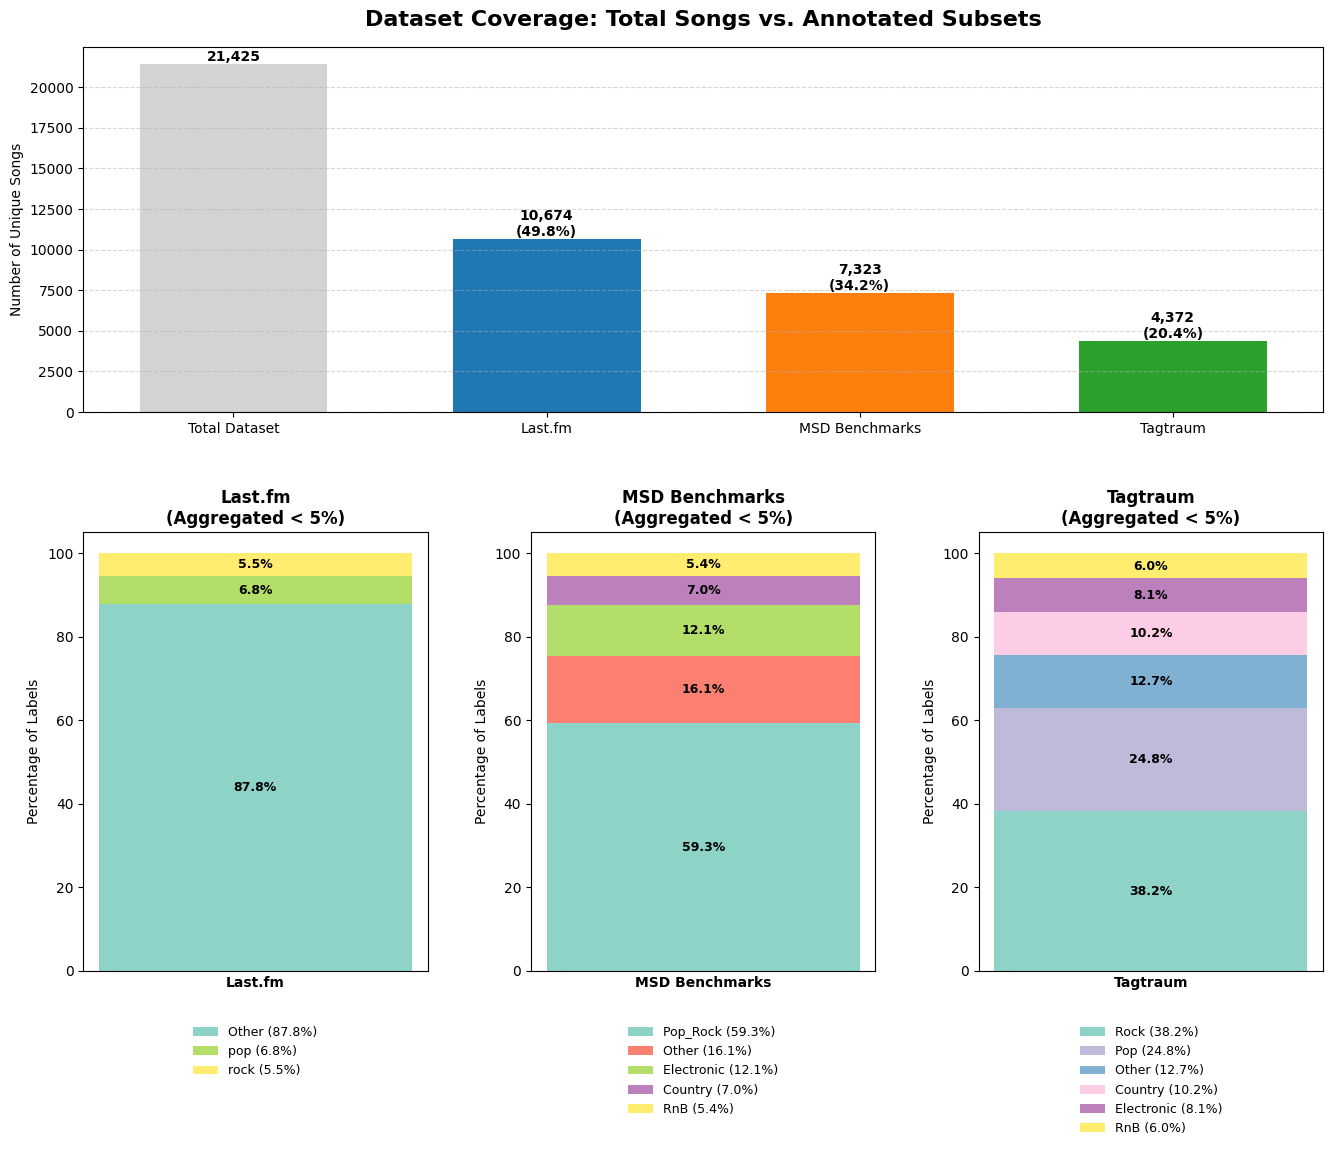

In [6]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from collections import defaultdict

def load_cleansed_ids(cleansed_ids_file):
    print(f'Loading cleansed IDs from {cleansed_ids_file}...')
    msd_ids = set()

    try:
        with open(cleansed_ids_file, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split()
                    if len(parts) >= 2:
                        msd_id = parts[1].strip()
                        if msd_id.startswith('TR') and len(msd_id) == 18:
                            msd_ids.add(msd_id)
    except FileNotFoundError:
        print(f"Error: Could not find file {cleansed_ids_file}")
        return set()

    print(f'Loaded {len(msd_ids):,} unique MSD IDs')
    return msd_ids


def process_label_provider_folder(folder_path, msd_ids_set):
    """
    Process a label provider folder.
    Returns:
        genre_counts: dict of {genre: count of songs}
        unique_labeled_count: int (number of unique songs found in this provider)
    """
    genre_counts = defaultdict(int)
    # Handle case where folder might not exist
    if not os.path.exists(folder_path):
        print(f"Warning: Folder not found: {folder_path}")
        return genre_counts, 0

    id_list_files = glob.glob(os.path.join(folder_path, 'id_list_*.txt'))

    labeled_songs = set()

    for file_path in id_list_files:
        # Extract genre name from filename
        filename = os.path.basename(file_path)
        genre = filename.replace('id_list_', "").replace('.txt', "")

        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    msd_id = line.strip()
                    if msd_id in msd_ids_set:
                        genre_counts[genre] += 1
                        labeled_songs.add(msd_id)
        except Exception as e:
            print(f'Error processing {file_path}: {e}')

    return dict(genre_counts), len(labeled_songs)


def aggregate_genres(genre_counts, threshold_ratio=0.10):
    """
    Aggregates genres that are below the threshold ratio into 'Other'.
    """
    total_labels = sum(genre_counts.values())
    if total_labels == 0:
        return {}, 0

    aggregated = defaultdict(int)

    # Sort genres to ensure consistent processing
    sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)

    for genre, count in sorted_genres:
        ratio = count / total_labels
        if ratio >= threshold_ratio:
            aggregated[genre] = count
        else:
            aggregated['Other'] += count

    # If 'Other' ends up being 0 (unlikely if threshold is used), remove it
    if aggregated['Other'] == 0 and 'Other' in aggregated:
        del aggregated['Other']

    # Re-sort so largest categories are first (and 'Other' usually ends up last or based on size)
    final_sorted = dict(sorted(aggregated.items(), key=lambda x: x[1], reverse=True))
    return final_sorted, total_labels


def create_combined_visualization(data_map, total_dataset_size):
    """
    Creates a figure with:
    1. Top: Bar plot of coverage (Total vs Providers).
    2. Bottom: 3 side-by-side stacked bars for genre distribution.
    """

    # Setup Figure and Grid
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1.2], hspace=0.3, wspace=0.3)

    # --- PLOT 1: Coverage Bar Plot (Top Row, spanning all columns) ---
    ax_cov = fig.add_subplot(gs[0, :])

    provider_names = ['Total Dataset'] + list(data_map.keys())
    # Counts: Total Dataset Size, followed by unique labeled songs for each provider
    counts = [total_dataset_size] + [data['unique_count'] for data in data_map.values()]

    # Colors: Grey for total, distinct colors for providers
    bar_colors = ['#d3d3d3'] + ['#1f77b4', '#ff7f0e', '#2ca02c']

    bars = ax_cov.bar(provider_names, counts, color=bar_colors, width=0.6)

    # Add labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax_cov.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:,}\n({(height/total_dataset_size)*100:.1f}%)' if height != total_dataset_size else f'{height:,}',
                    ha='center', va='bottom', fontweight='bold')

    ax_cov.set_title('Dataset Coverage: Total Songs vs. Annotated Subsets', fontsize=16, fontweight='bold', pad=15)
    ax_cov.set_ylabel('Number of Unique Songs')
    ax_cov.grid(axis='y', linestyle='--', alpha=0.5)

    # --- PLOT 2: Stacked Bar Plots (Bottom Row) ---

    for idx, (provider_name, data) in enumerate(data_map.items()):
        ax = fig.add_subplot(gs[1, idx])

        # Aggregate genres < 10%
        aggregation_threshold = 0.05
        agg_genres, total_labels = aggregate_genres(data['counts'], threshold_ratio=aggregation_threshold)

        if total_labels == 0:
            ax.text(0.5, 0.5, "No Data", ha='center')
            continue

        # Prepare data for stacking
        genres = list(agg_genres.keys())
        values = list(agg_genres.values())
        ratios = np.array(values) / total_labels * 100

        # Create stacked bar
        bottom = 0
        # Use a colormap
        colors = plt.cm.Set3(np.linspace(0, 1, len(genres)))

        for i, (genre, ratio) in enumerate(zip(genres, ratios)):
            p = ax.bar(provider_name, ratio, bottom=bottom, label=f"{genre} ({ratio:.1f}%)",
                       color=colors[i], width=0.5)

            # Add text in the middle of the bar segment
            if ratio > 5: # Only label if segment is big enough
                ax.text(0, bottom + ratio/2, f"{ratio:.1f}%",
                        ha='center', va='center', fontsize=9, fontweight='bold', color='black')

            bottom += ratio

        ax.set_title(f'{provider_name}\n(Aggregated < {int(aggregation_threshold * 100)}%)', fontsize=12, fontweight='bold')
        ax.set_ylim(0, 105) # Give space for legend if needed, though legend is external usually
        ax.set_ylabel('Percentage of Labels')

        # Remove X ticks as the title serves as the label
        ax.set_xticks([])
        ax.set_xlabel(provider_name, fontweight='bold')

        # Add Legend
        # placing legend outside or below to avoid clutter
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1, fontsize=9, frameon=False)

    # Save and Show
    output_path = os.path.join(os.getcwd(), '..', 'plots', 'combined_genre_analysis.png')
    # Ensure plot directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    print(f"Saving plot to {output_path}")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


def analyze_genre_distributions():
    """
    Main function to analyze and plot.
    """
    # Adjust these paths if necessary based on your exact folder structure
    base_dir = os.path.join(os.getcwd(), '..', 'lpd_5')
    cleansed_ids_file = os.path.join(base_dir, 'cleansed_ids.txt')
    labels_folder = os.path.join(base_dir, 'labels')

    label_providers = {
        'Last.fm': os.path.join(labels_folder, 'lastfm'),
        'MSD Benchmarks': os.path.join(labels_folder, 'amg'),
        'Tagtraum': os.path.join(labels_folder, 'tagtraum')
    }

    # 1. Load Total Dataset IDs
    msd_ids_set = load_cleansed_ids(cleansed_ids_file)

    if not msd_ids_set:
        print('No valid MSD IDs found. Check file paths.')
        return

    # 2. Collect Data
    data_map = {}

    print("\nProcessing Providers...")
    for name, folder in label_providers.items():
        print(f"Scanning {name}...")
        counts, unique_count = process_label_provider_folder(folder, msd_ids_set)
        data_map[name] = {
            'counts': counts,
            'unique_count': unique_count
        }

    # 3. Visualize
    create_combined_visualization(data_map, len(msd_ids_set))

analyze_genre_distributions()

Load data from file

Generating plot...
Saving plot to C:\Users\mbrun\Documents\University_Branche\Project\webserver\backend\ml_model\experiments\..\plots\drum_pitches.png


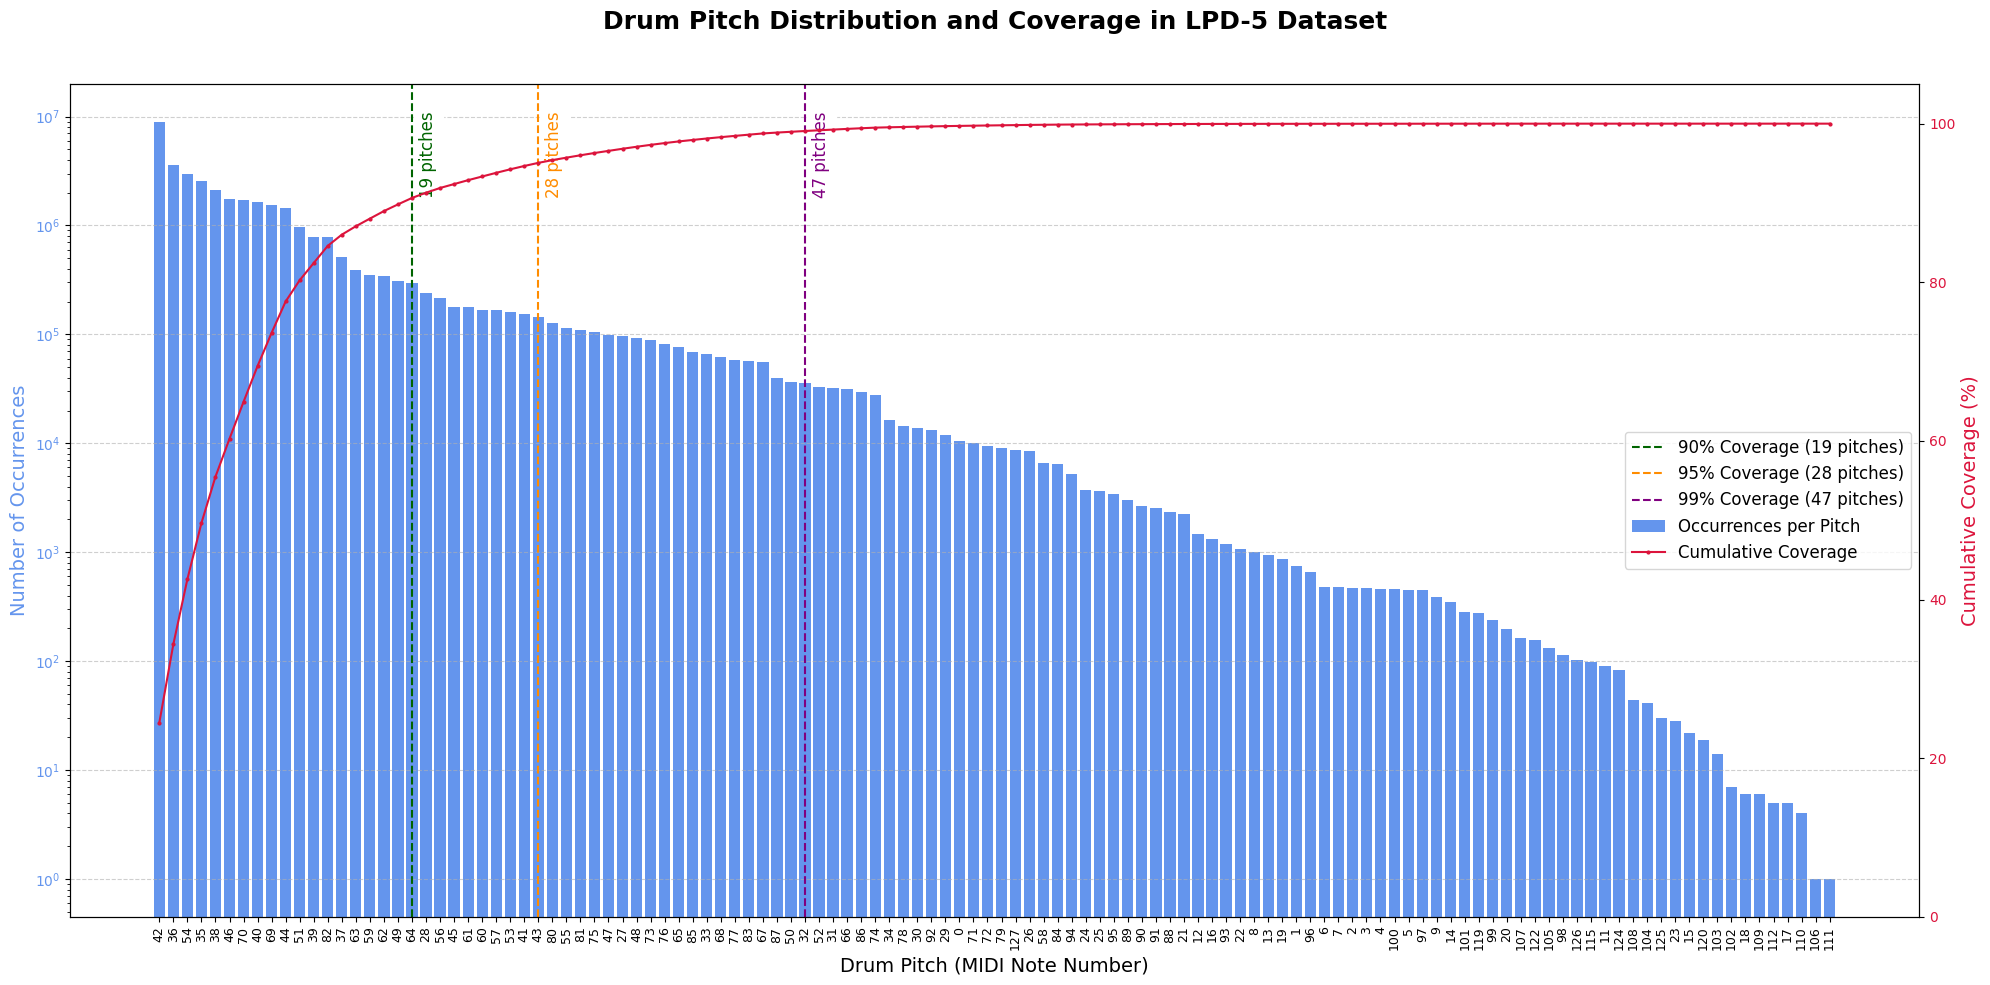

In [28]:
def analyze_and_plot_drum_pitches():
    """
    Analyzes drum pitch occurrences in the LPD-5 dataset and generates a
    plot showing the distribution and coverage.
    """
    file_paths = glob.glob(os.path.join(os.getcwd(), '..', 'lpd_5/lpd_5_cleansed/*/*/*/*/*.npz'))
    result_filepath = os.path.join(os.getcwd(), '..', 'plots', 'drum_pitches')

    if not os.path.exists(f'{result_filepath}.pkl'):
        drum_pitch_counts = Counter()

        print(f'Processing {len(file_paths)} files...')
        for file_path in tqdm(file_paths, desc='Analyzing files'):
            try:
                m = pypianoroll.load(file_path)

                drum_tracks = [t for t in m.tracks if t.is_drum]
                if not drum_tracks:
                    continue

                for drum_track in drum_tracks:
                    # Sum occurrences for each pitch across the time axis
                    pitch_occurrences = np.sum(drum_track.pianoroll > 0, axis=0)

                    for pitch, count in enumerate(pitch_occurrences):
                        if count > 0:
                            drum_pitch_counts[pitch] += int(count)

            except Exception as e:
                print(f'Warning: Error processing {file_path}: {e}')

        with open(f'{result_filepath}.pkl', 'wb') as f:
            pickle.dump(drum_pitch_counts, f)
    else:
        print('Load data from file')
        with open(f'{result_filepath}.pkl', 'rb') as f:
            drum_pitch_counts = pickle.load(f)

    # --- Data Preparation for Plotting ---
    total_notes = sum(drum_pitch_counts.values())
    sorted_pitches_data = sorted(drum_pitch_counts.items(), key=lambda item: item[1], reverse=True)

    # Unzip into separate lists for plotting
    pitches, counts = zip(*sorted_pitches_data)

    # Calculate cumulative coverage as a percentage
    cumulative_counts = np.cumsum(counts)
    cumulative_coverage = cumulative_counts / total_notes * 100

    # --- Plotting ---
    print('\nGenerating plot...')
    fig, ax1 = plt.subplots(figsize=(20, 10))

    # Bar plot for pitch counts (primary y-axis on the left)
    x_indices = np.arange(len(pitches))
    ax1.bar(x_indices, counts, color='cornflowerblue', label='Occurrences per Pitch')
    ax1.set_xlabel('Drum Pitch (MIDI Note Number)', fontsize=14)
    ax1.set_ylabel('Number of Occurrences', color='cornflowerblue', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='cornflowerblue')
    # Set the x-axis to show the actual MIDI pitch numbers
    ax1.set_xticks(x_indices)
    ax1.set_xticklabels(pitches, rotation=90, fontsize=9)
    ax1.set_yscale('log') # Use a log scale for better visibility of less common pitches

    # Line plot for cumulative coverage (secondary y-axis on the right)
    ax2 = ax1.twinx()
    ax2.plot(x_indices, cumulative_coverage, color='crimson', marker='.', markersize=4, linestyle='-', label='Cumulative Coverage')
    ax2.set_ylabel('Cumulative Coverage (%)', color='crimson', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='crimson')
    ax2.set_ylim(0, 105) # Give 5% padding at the top

    # Add vertical lines and text for coverage thresholds
    colors = {90: 'darkgreen', 95: 'darkorange', 99: 'purple'}
    for p in [90, 95, 99]:
        try:
            # Find the first index where coverage exceeds the threshold
            num_pitches_needed = np.where(cumulative_coverage >= p)[0][0]
            label = f'{p}%'
            color = colors[p]

            # Draw the vertical line
            ax1.axvline(x=num_pitches_needed, color=color, linestyle='--',
                        label=f'{label} Coverage ({num_pitches_needed + 1} pitches)')

            # Add a text annotation to the plot
            ax1.text(num_pitches_needed + 0.5, max(counts) * 0.5, f'{num_pitches_needed + 1} pitches',
                     rotation=90, color=color, va='center', fontsize=12, backgroundcolor='white')

        except IndexError:
            print(f'Warning: Could not find index to reach {p}% coverage.')

    # --- Final Touches ---
    fig.suptitle('Drum Pitch Distribution and Coverage in LPD-5 Dataset', fontsize=18, weight='bold')
    # Combine legends from both axes into a single box
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center right', fontsize=12)

    ax1.grid(True, which='major', axis='y', linestyle='--', alpha=0.6)
    fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for the suptitle

    # Save the plot
    print(f'Saving plot to {result_filepath}.png')
    plt.savefig(f'{result_filepath}.png', dpi=300, bbox_inches='tight')
    plt.show()

analyze_and_plot_drum_pitches()

Loading results from file.
Plot saved to C:\Users\mbrun\Documents\University_Branche\Project\webserver\backend\ml_model\experiments\..\plots\average_notes_per_time_step.png


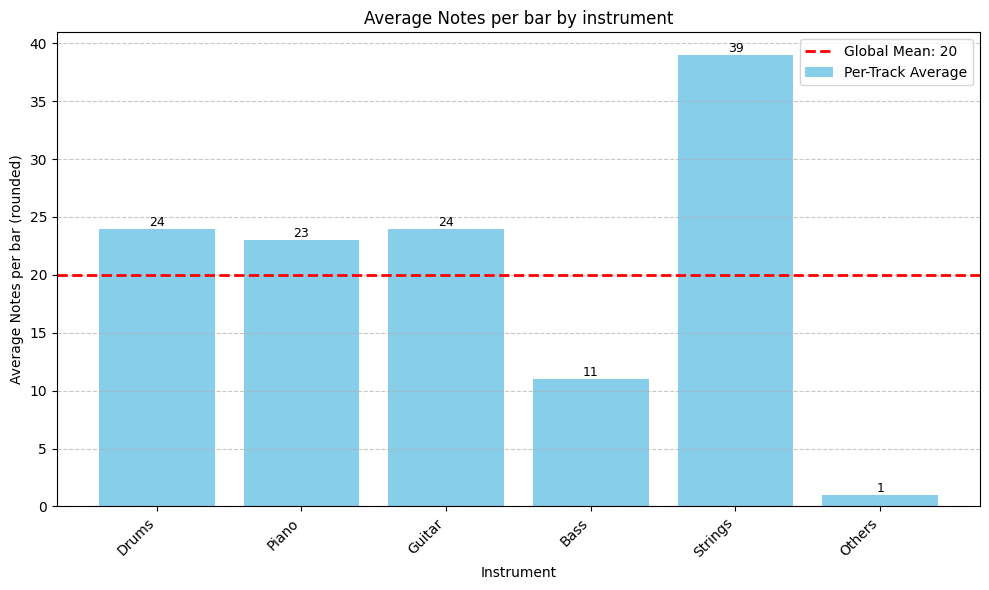

In [27]:
def plot_average_notes_per_bar():
    """Calculate average notes per time step"""
    result_filepath = os.path.join(os.getcwd(), '..', 'plots', 'average_notes_per_time_step')

    if not os.path.exists(f'{result_filepath}.pkl'):
        # Get all files
        file_paths = glob.glob(os.path.join(os.getcwd(), '..', 'lpd_5/lpd_5_cleansed/*/*/*/*/*.0.npy'))
        print(f'Found {len(file_paths)} files to process')

        num_processes = mp.cpu_count()
        print(f'Using {num_processes} processes')

        # Total number of notes and timesteps per track
        total_counts = {
            'Drums': [0, 0],
            'Piano': [0, 0],
            'Guitar': [0, 0],
            'Bass': [0, 0],
            'Strings': [0, 0],
            'Others': [0, 0],
        }

        # Process files using multiprocessing
        with Pool(processes=num_processes) as pool:
            results = list(tqdm(
                pool.imap_unordered(average_notes_per_timestep_for_file, file_paths, chunksize=50),
                total=len(file_paths),
                desc='Processing files'
            ))

        # Aggregate results
        failed_files = []
        for result in results:
            if result['success']:
                for track, (track_count, track_timestep_count) in result['counts'].items():
                    total_counts[track][0] += track_count
                    total_counts[track][1] += track_timestep_count
            else:
                # Print the first 10 failed items and store the rest
                if len(failed_files) <= 10:
                    print(f'{result['file_path']}: {result['error']}')

                failed_files.append((result['file_path'], result['error']))

        with open(f'{result_filepath}.pkl', 'wb') as f:
            pickle.dump(total_counts, f)
    else:
        print(f'Loading results from file.')
        with open(f'{result_filepath}.pkl', 'rb') as f:
            total_counts = pickle.load(f)

    # --- Calculate Averages ---
    track_means = {}
    grand_total_notes = 0
    grand_total_time_steps = 0

    # Iterate through the dictionary to calculate means and grand totals
    # Multiply them by 16 to go from average per sixteenth note to average per bar
    for track, (notes, steps) in total_counts.items():
        grand_total_notes += notes
        grand_total_time_steps += steps
        track_means[track] = int(round((notes / steps) * 16))

    global_mean = int(round((grand_total_notes / grand_total_time_steps) * 16))

    # Prepare data for plotting
    labels = list(track_means.keys())
    means = list(track_means.values())

    plt.figure(figsize=(10, 6)) # Set figure size

    # Create bar chart
    bars = plt.bar(labels, means, label='Per-Track Average', color='skyblue')

    # Add the global mean as a horizontal line
    plt.axhline(global_mean, color='r', linestyle='--', linewidth=2, label=f'Global Mean: {global_mean}')

    # Add labels and title
    plt.xlabel('Instrument')
    plt.ylabel('Average Notes per bar (rounded)')
    plt.title('Average Notes per bar by instrument')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability

    # Add data labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval}', va='bottom', ha='center', fontsize=9)

    # Add legend
    plt.legend()

    # Add grid for easier reading
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Save the plot to the file defined at the top
    plt.savefig(f'{result_filepath}.png')
    print(f'Plot saved to {result_filepath}.png')

    plt.show()

plot_average_notes_per_bar()